# 5. Running a full analysis

*Written by Jin Hyun Cheong and Eshin Jolly*

In this tutorial we'll perform a real analysis on part of the open dataset from ["A Data-Driven Characterisation Of Natural Facial Expressions When Giving Good And Bad News"](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1008335) by Watson & Johnston 2020.  You can try it out interactively in Google Collab: [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/cosanlab/py-feat/blob/master/notebooks/content/04_fex_analysis.ipynb)

In the original paper the authors had 3 speakers deliver *good* or *bad* news while filming their facial expressions. They found that could accurately "decode" each condition based on participants' facial expressions extracted either using a custom multi-chanel-gradient model or action units (AUs) extracted using [Open Face](https://github.com/TadasBaltrusaitis/OpenFace). 

In this tutorial we'll show how easily it is to not only reproduce their decoding analysis with py-feat, but just as easily perform additional analyses. Specifically we'll:

1. Download 20 of the first subject's videos (the full dataset is available on [OSF](https://osf.io/6tbwj/)
2. Extract facial features using the `Detector`
3. Aggregate and summarize detections per video using `Fex`
2. Train and test a decoder to classify *good* vs *bad* news using extracted emotions, AUs, and poses
3. Run a fMRI style "mass-univariate" comparison across all AUs between conditions
4. Run a time-series analysis comparing videos based on the time-courses of extracted facial features 

In [1]:
# Uncomment the line below and run this only if you're using Google Collab
# !pip install -q py-feat

# 5.1 Download the data

Here's we'll download and save the first 20 video files and their corresponding attributes from OSF. The next cell should run quickly on Google Collab, but will depend on your own internet connection if you're executing this notebook locally. You can rerun this cell in case the download fails for any reason, as it should skip downloading existing files:

In [1]:
import os
import subprocess
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
import seaborn as sns
from tqdm import tqdm
sns.set_context("talk")

files_to_download = {
    "4c5mb": 'clip_attrs.csv',
    "n6rt3": '001.mp4',
    "3gh8v": '002.mp4',
    "twqxs": '003.mp4',
    "nc7d9": '004.mp4',
    "nrwcm": '005.mp4',
    "2rk9c": '006.mp4',
    "mxkzq": '007.mp4',
    "c2na7": '008.mp4',
    "wj7zy": '009.mp4',
    "mxywn": '010.mp4',
    "6bn3g": '011.mp4',
    "jkwsp": '012.mp4',
    "54gtv": '013.mp4',
    "c3hpm": '014.mp4',
    "utdqj": '015.mp4',
    "hpw4a": '016.mp4',
    "94swe": '017.mp4',
    "qte5y": '018.mp4',
    "aykvu": '019.mp4',
    "3d5ry": '020.mp4',
}

for fid, fname in files_to_download.items():
    if not os.path.exists(fname):
        print(f"Downloading: {fname}")
        subprocess.run(f"wget -O {fname} --content-disposition https://osf.io/{fid}/download".split())

videos = np.sort(glob("*.mp4"))

# Load in attributes
clip_attrs = pd.read_csv("clip_attrs.csv")

# Add in file names and rename conditions
clip_attrs = clip_attrs.assign(
    input=clip_attrs.clipN.apply(lambda x: str(x).zfill(3) + ".mp4"),
    condition=clip_attrs["class"].replace({"gn": "goodNews", "ists": "badNews"}),
)

# We're only using a subset of videos for this tutorial so drop the rest
clip_attrs = clip_attrs.query("input in @videos")

print(f"Downloaded {len(videos)} videos")
print(f"Downloaded attributes files with {clip_attrs.shape[0]} rows")

Downloaded 20 videos
Downloaded attributes files with 20 rows


# 5.2 Extract facial features using `Detector`

Now we'll initialize a new `Detector`, process each frame of each video using `.detect_video()`, and save the results to csv files named after the video.

In [ ]:
from feat import Detector

# Initialize the default detector
detector = Detector()

# Loop over and process each video and save results to csv
for video in tqdm(videos):
    out_name = video.replace(".mp4", ".csv")
    if not os.path.exists(out_name):

        print(f"Processing: {video}")

        # This is the line that does detection!
        fex = detector.detect_video(video)

        fex.to_csv(out_name, index=False)

# 5.3. Aggregate detections using a `Fex` dataframe

Then we can use `read_feat` to load each CSV file and concatenate them together:

In [6]:
from feat.utils.io import read_feat

fex = pd.concat(map(lambda video: read_feat(video.replace(".mp4", ".csv")), videos))

print(f"Unique videos: {fex.inputs.nunique()}")
print(f"Total processed frames: {fex.shape[0]}")
print(f"Avg frames per video: {fex.groupby('input').size().mean()}")

Unique videos: 20
Total processed frames: 947
Avg frames per video: 47.35


Our `Fex` dataframe now contains all detections for all frames of each video

In [7]:
fex.shape
fex.head()

(947, 174)

,FaceRectX,FaceRectY,FaceRectWidth,FaceRectHeight,FaceScore,x_0,x_1,x_2,x_3,x_4,...,anger,disgust,fear,happiness,sadness,surprise,neutral,input,frame,approx_time
0,364.351590,281.705972,393.321784,538.626011,0.999326,355.590267,361.166635,370.024031,382.002333,405.379242,...,0.000438,0.000117,0.000483,0.981574,0.001495,0.013396,0.002497,001.mp4,0,00:00
1,364.420098,281.698321,393.282234,538.731126,0.999327,355.947047,361.429636,370.189673,382.098332,405.381871,...,0.000422,0.000110,0.000471,0.981490,0.001407,0.013663,0.002437,001.mp4,1,00:00
2,366.712348,280.100516,393.075675,538.872332,0.999371,357.488551,363.557662,372.905629,385.126006,408.333512,...,0.000379,0.000112,0.000329,0.988872,0.001477,0.006877,0.001954,001.mp4,2,00:00
3,369.679081,279.800566,392.800373,541.545800,0.999298,358.248297,364.062520,373.173968,385.128103,407.907217,...,0.000451,0.000122,0.000229,0.989229,0.001519,0.005104,0.003346,001.mp4,3,00:00
4,368.641343,273.729074,397.080568,550.337162,0.999240,353.728640,360.555682,370.127252,382.294048,405.861680,...,0.000388,0.000067,0.000447,0.976272,0.001275,0.016979,0.004573,001.mp4,4,00:00


## 5.3.1 Summarize data with `Fex.sessions`

`Fex` dataframes have a special attribute called `.sessions` that act as a grouping factor to make it easier to compute summary statistics with any of the `.extract_*` methods. By default `.sessions` is `None`, but you can use the `.update_sessions()` to return **a new Fex dataframe** with `.sessions` set. 

For example, if we update the sessions to be the name of each video, then `.extract_mean()` will group video-frames (rows) by video making it easy to compute a single summary statistic per file:

In [8]:
by_video = fex.update_sessions(fex["input"])

# Compute the mean per video
video_means = by_video.extract_mean()

video_means # 20 rows for 20 videos

,mean_FaceRectX,mean_FaceRectY,mean_FaceRectWidth,mean_FaceRectHeight,mean_FaceScore,mean_x_0,mean_x_1,mean_x_2,mean_x_3,mean_x_4,...,mean_AU28,mean_AU43,mean_anger,mean_disgust,mean_fear,mean_happiness,mean_sadness,mean_surprise,mean_neutral,mean_frame
001.mp4,361.693876,276.801922,390.643836,538.546526,0.999415,351.745947,358.669057,369.211596,382.289621,405.340749,...,0.400157,0.078763,0.000840,0.000170,0.002119,0.955028,0.011139,0.022887,0.007818,19.5
002.mp4,362.782907,273.463460,381.666967,534.798252,0.999420,351.152403,356.936973,366.408657,378.847147,401.092449,...,0.310074,0.123018,0.000609,0.000115,0.001898,0.879776,0.012571,0.094248,0.010782,13.5
003.mp4,356.546617,271.015871,388.101834,541.721541,0.999401,342.375212,346.903972,354.548829,365.250301,386.696666,...,0.263471,0.037146,0.000355,0.000061,0.001733,0.707242,0.001066,0.285287,0.004256,23.0
004.mp4,340.658119,271.997003,390.052859,545.905496,0.999425,328.644936,334.260224,342.829941,354.501717,376.853730,...,0.264972,0.099364,0.000721,0.000068,0.001341,0.847641,0.012390,0.132939,0.004900,22.0
005.mp4,322.252894,292.223503,393.885578,539.983786,0.999394,312.148711,317.922322,327.292733,339.933222,363.364786,...,0.366397,0.132650,0.000226,0.000043,0.000490,0.986752,0.001082,0.009684,0.001723,22.0
006.mp4,351.829324,263.138842,383.265317,541.386626,0.999457,339.691768,343.841731,351.142231,361.316873,382.081545,...,0.366849,0.059786,0.000246,0.000036,0.000628,0.941467,0.001282,0.054525,0.001816,23.5
007.mp4,358.451365,267.047528,385.200341,539.094825,0.999380,345.372773,348.641482,355.122228,364.639966,384.731837,...,0.326419,0.043416,0.000374,0.000058,0.002243,0.933058,0.003285,0.057281,0.003701,13.0
008.mp4,335.531841,269.932394,389.309414,543.007503,0.999335,322.590086,328.698168,337.769330,348.969558,369.878785,...,0.482863,0.037955,0.000327,0.000091,0.004953,0.592064,0.003459,0.393644,0.005462,17.5
009.mp4,341.377368,258.612550,384.471775,547.748099,0.999307,328.585905,334.560713,343.619836,355.424001,377.394425,...,0.428292,0.048874,0.000317,0.000195,0.014244,0.536781,0.003003,0.442032,0.003427,20.5
010.mp4,350.612259,285.415234,382.804314,537.392594,0.999450,336.439669,342.711365,352.625989,365.147914,388.132257,...,0.452048,0.068882,0.000243,0.000051,0.005075,0.691970,0.008150,0.290069,0.004443,26.5


Then we can grab the AU detections and call standard pandas methods like `.loc` and `.plot`:

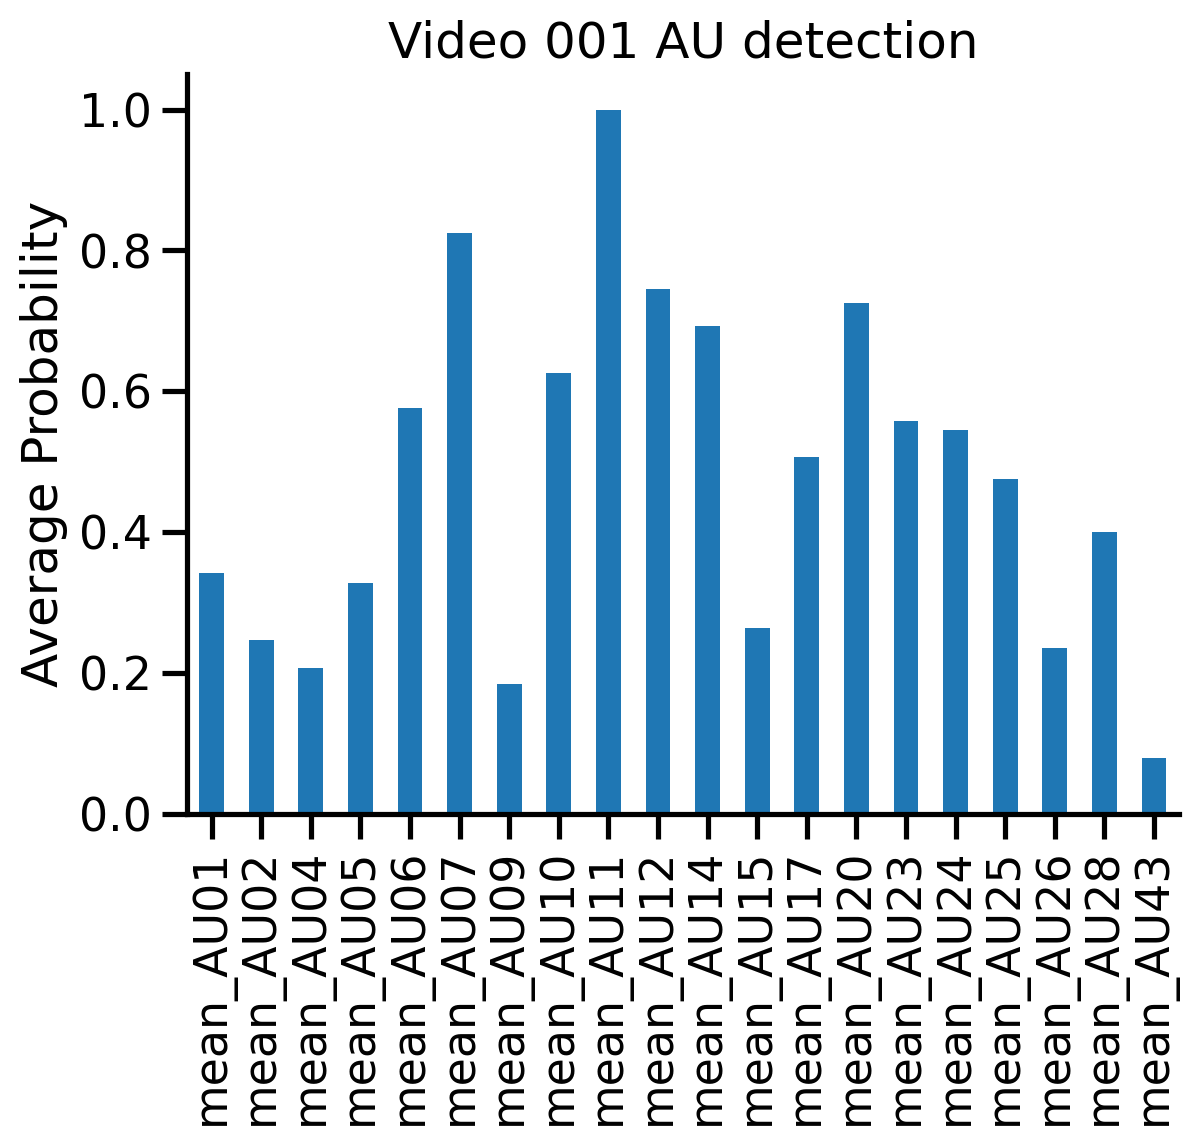

In [11]:
# Grab the aus just for video 1
video001_aus = video_means.aus.loc['001.mp4']
# video001_aus = video_means.aus.loc['001.csv'] # if loading pre-computed csv

# Plot them
ax = video001_aus.plot(kind='bar', title='Video 001 AU detection');
ax.set(ylabel='Average Probability');
sns.despine();

## 5.3.2 Chaining operations

`.update_sessions()` always returns a **copy** of the Fex object, so that you can **chain** operations together including existing pandas methods like `.plot()`. Here's an example passing a dictionary to `.update_sessions()`, which maps between old and new session names:

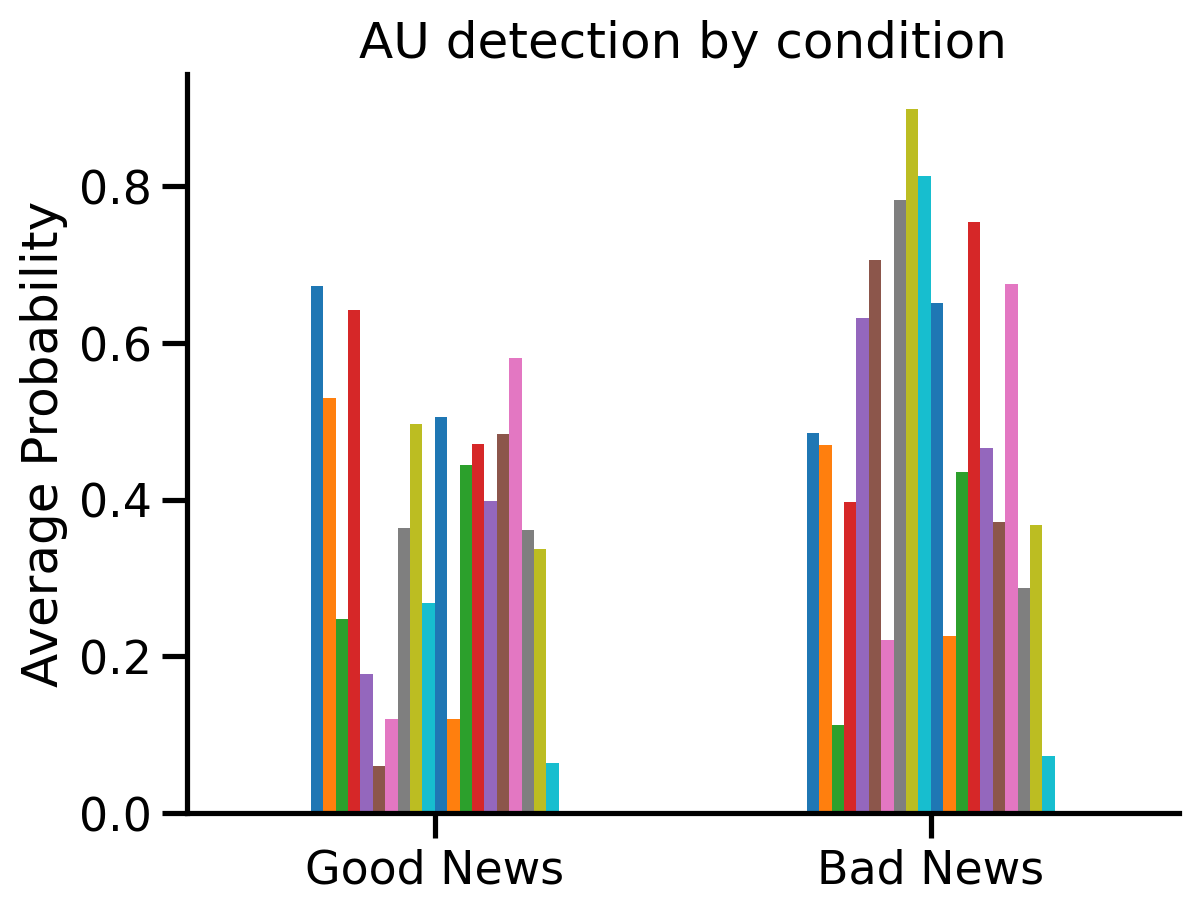

In [17]:
# Which condition each video belonged to
video2condition = dict(
    zip(
        # if loading pre-computed csv
        # clip_attrs["input"].str.replace(".mp4", ".csv", regex=False),
        clip_attrs["input"],
        clip_attrs["condition"],
    )
)

# Update sessions to group by condition, compute means (per condition), and make a
# barplot of the mean AUs for each condition
ax = (
    by_video.update_sessions(video2condition)
    .extract_mean()
    .aus.plot(kind="bar", legend=False, title="Mean AU detection by condition")
)
ax.set(ylabel='Average Probability', title='AU detection by condition', xticklabels=['Good News', 'Bad News']);
plt.xticks(rotation=0);
sns.despine();

We can also focus in on the AUs associated with happiness:

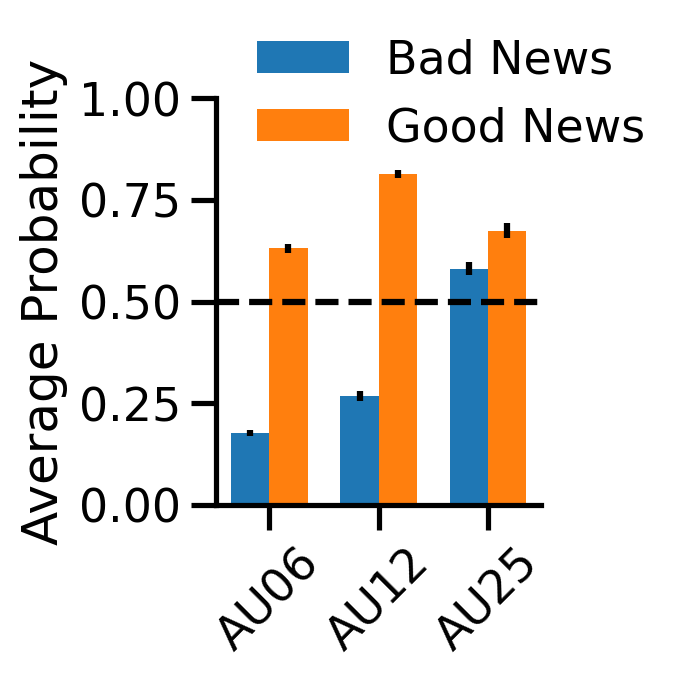

In [27]:
aus = ["AU06", "AU12", "AU25"]  # from https://py-feat.org/pages/au_reference.html

# Update the sessions to condition compute summary stats
summary = by_video.update_sessions(video2condition).extract_summary(
    mean=True, sem=True, std=False, min=False, max=False
)

# Organize them for plotting
bad_means = summary.loc["badNews", [f"mean_{au}" for au in aus]]
bad_sems = summary.loc["badNews", [f"sem_{au}" for au in aus]]
good_means = summary.loc["goodNews", [f"mean_{au}" for au in aus]]
good_sems = summary.loc["goodNews", [f"sem_{au}" for au in aus]]

# Plot
fig, ax = plt.subplots(figsize=(3, 4))
ind = np.arange(len(bad_means))
width = 0.35
rects1 = ax.bar(ind - width / 2, bad_means, width, yerr=bad_sems, label="Bad News");
rects2 = ax.bar(ind + width / 2, good_means, width, yerr=good_sems, label="Good News");
ax.set(ylabel="Average Probability", title="", xticks=ind, xticklabels=aus, ylim=(0, 1));
ax.legend(loc="upper left", frameon=False, bbox_to_anchor=(0, 1.25));
plt.axhline(0.5, ls="--", color="k");
sns.despine();
plt.xticks(rotation=45);
plt.tight_layout();
plt.savefig('./fig_maker/au_diffs.pdf', bbox_inches='tight');

# 5.4 Comparing the condition difference across AUs using regression

One way we can compare what AUs in the plot show significant differences is by using the `.regress()` method along with numerical contrast codes. For example we can test the difference in activation of every AU when participants delivered *good* vs *bad* news.

This is analogous to the "mass-univariate" GLM approach in fMRI research, and allows us to identify what AUs are significantly more active in one condition vs another:

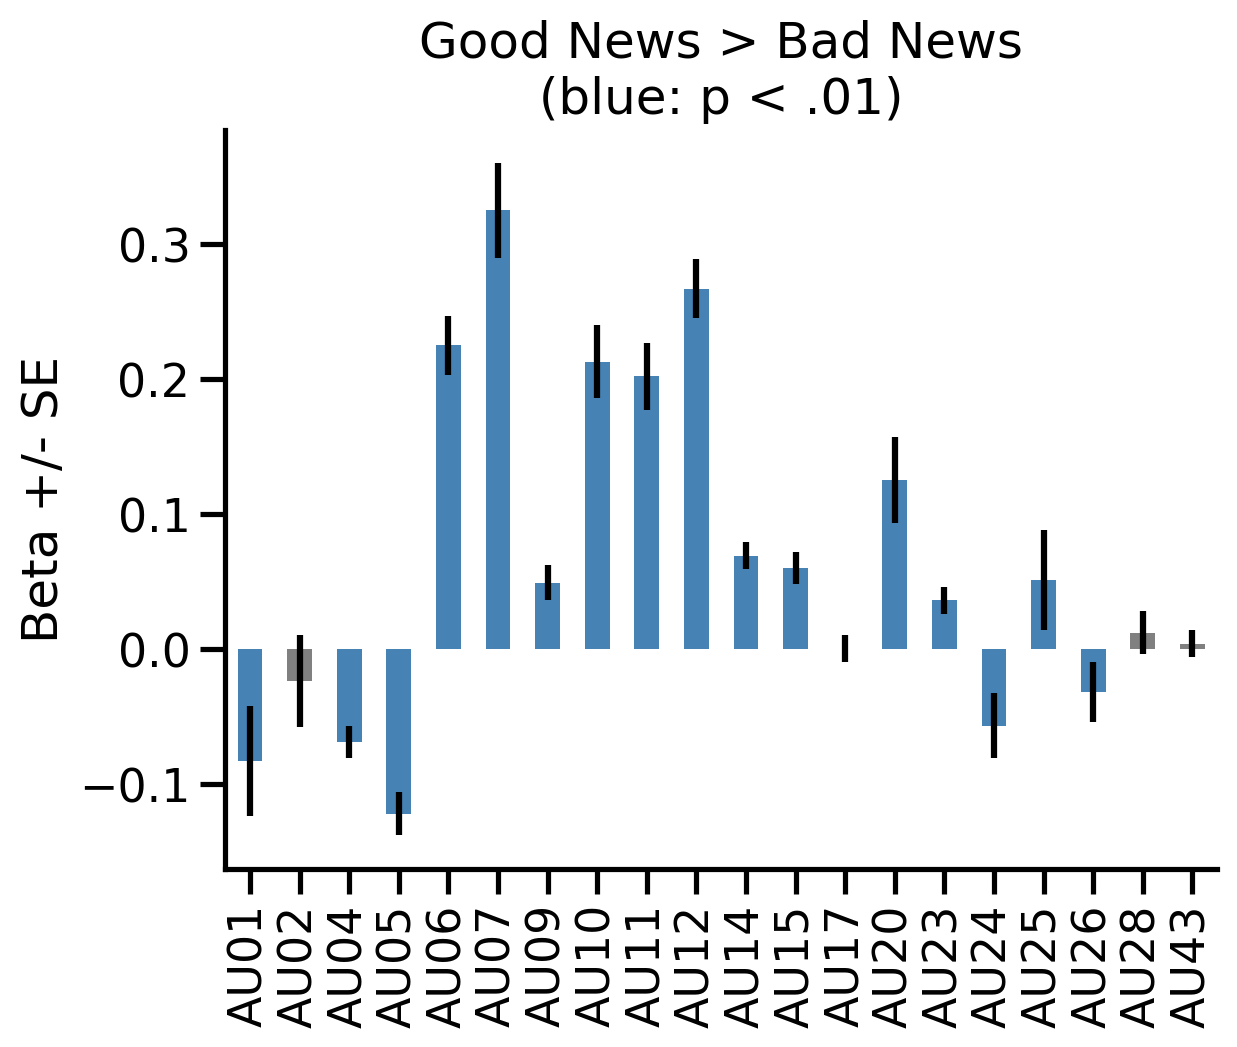

In [28]:
# Save the by_condition fex from above
by_condition = video_means.update_sessions(video2condition)

# We set numerical contrasts to compare mean good news > mean bad news
by_condition_codes = by_condition.update_sessions({"goodNews": 1., "badNews": -1})

# Now we perform a regression (t-test) at every AU
b, se, t, p, df, residuals = by_condition_codes.regress(
    X="sessions", y="aus", fit_intercept=True
)

# We can perform bonferroni correction for multiple comparisons:
p_bonf = p / p.shape[1]

results = pd.concat(
    [
        b.round(3).loc[["sessions"]].rename(index={"sessions": "betas"}),
        se.round(3).loc[["sessions"]].rename(index={"sessions": "ses"}),
        t.round(3).loc[["sessions"]].rename(index={"sessions": "t-stats"}),
        df.round(3).loc[["sessions"]].rename(index={"sessions": "dof"}),
        p_bonf.round(3).loc[["sessions"]].rename(index={"sessions": "p-values"}),
    ]
)

ax = results.loc["betas"].plot(
    kind="bar",
    yerr=results.loc["ses"],
    color=[
        "steelblue" if elem else "gray"
        for elem in results.loc["p-values"] < 0.01
    ],
    title="Good News > Bad News\n(blue: p < .01)",
);
xticks = ax.get_xticklabels();
xticks = [elem.get_text().split('_')[-1] for elem in xticks]
ax.set_xticklabels(xticks);
ax.set_ylabel('Beta +/- SE');
sns.despine();

# 5.5 Decoding condition from facial features

We can easily perform an analysis just like Watson et al, by training a LinearDiscriminantAnalysis (LDA) decoder to classify which condition a video came from based on average **AU** and **headpose** detections.

To do this we can use the `.predict()` which behaves just like `.regress()` but also requires a `sklearn` `Estimator`. We can use keyword arguments to perform 10-fold cross-validation to test the accuracy of each decoder:

emotions model accuracy: 100% +/- 0%
aus model accuracy: 100% +/- 0%
poses model accuracy: 80% +/- 33.2%
emotions,poses model accuracy: 95% +/- 15%
aus,poses model accuracy: 95% +/- 15%


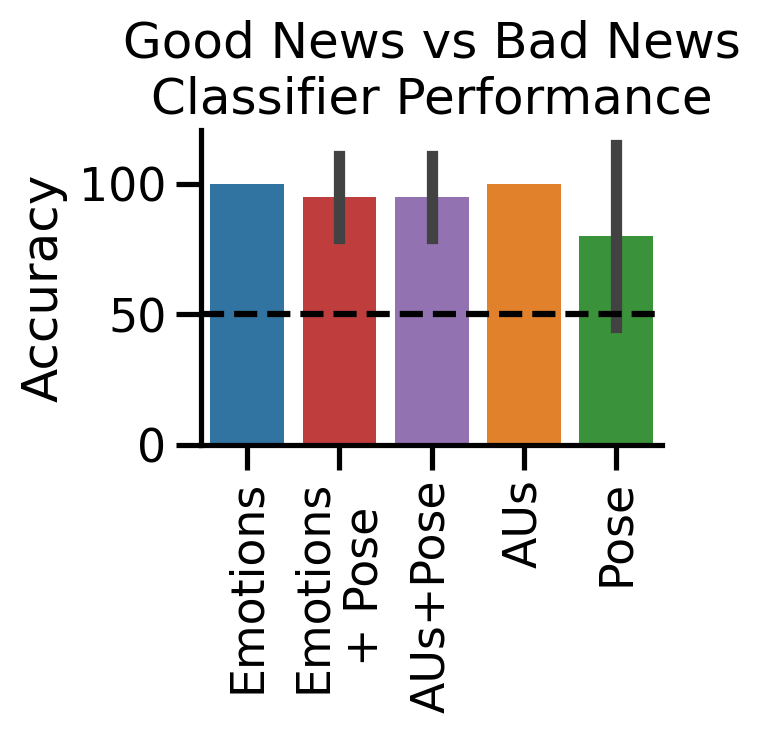

In [36]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import (
    StandardScaler,
)  # always a good idea to normalize your features!
from sklearn.pipeline import make_pipeline

# List of different models we'll train
feature_list = ["emotions", "aus", "poses", "emotions,poses", "aus,poses"]
results = []
models = {}

for features in feature_list:

    # .predict is just like .regress, but this time session is our y.
    model, accuracy = by_condition.predict(
        X=features,
        y="sessions",
        model=make_pipeline(StandardScaler(), LinearDiscriminantAnalysis()),
        cv_kwargs={"cv": 10},
    )

    # Save the model
    models[features] = model

    # Save the performance for plotting
    results.append(
        pd.DataFrame(
            {"Accuracy": accuracy * 100, "Features": [features] * len(accuracy)}
        )
    )
    # Print performance
    print(
        f"{features} model accuracy: {accuracy.mean()*100:.3g}% +/- {accuracy.std()*100:.3g}%"
    )

# Concat results into a single dataframe and tweak column names
results = pd.concat(results).assign(
    Features=lambda df: df.Features.map(
        {
            "emotions": "Emotions",
            "poses": "Pose",
            "aus": "AUs",
            "emotions,poses": "Emotions\n+ Pose",
            "aus,poses": "AUs+Pose",
        }
    )
)
# Plot it
# with sns.plotting_context("talk", font_scale=1.8):
f, ax = plt.subplots(1, 1, figsize=(3.75,4));
ax = sns.barplot(
    x="Features",
    y="Accuracy",
    errorbar="sd",
    dodge=False,
    hue="Features",
    data=results,
    ax=ax,
    order=["Emotions", "Emotions\n+ Pose", "AUs+Pose", "AUs", "Pose"],
);
ax.get_legend().remove();
ax.set_title("Good News vs Bad News\nClassifier Performance");
ax.set(ylabel="Accuracy", xlabel="");
sns.despine();
plt.axhline(y=50, ls="--", color="k");
plt.xticks(rotation=90);
plt.tight_layout();

plt.savefig('./fig_maker/decoding_acc.pdf', bbox_inches='tight');

## 5.5.1 Visualizing decoder weights
Using what we learned in the previous tutorial, we can visualize the coefficients for any models that used AU features. This allows us to "see" the underlying facial expression that the classifier learned! 

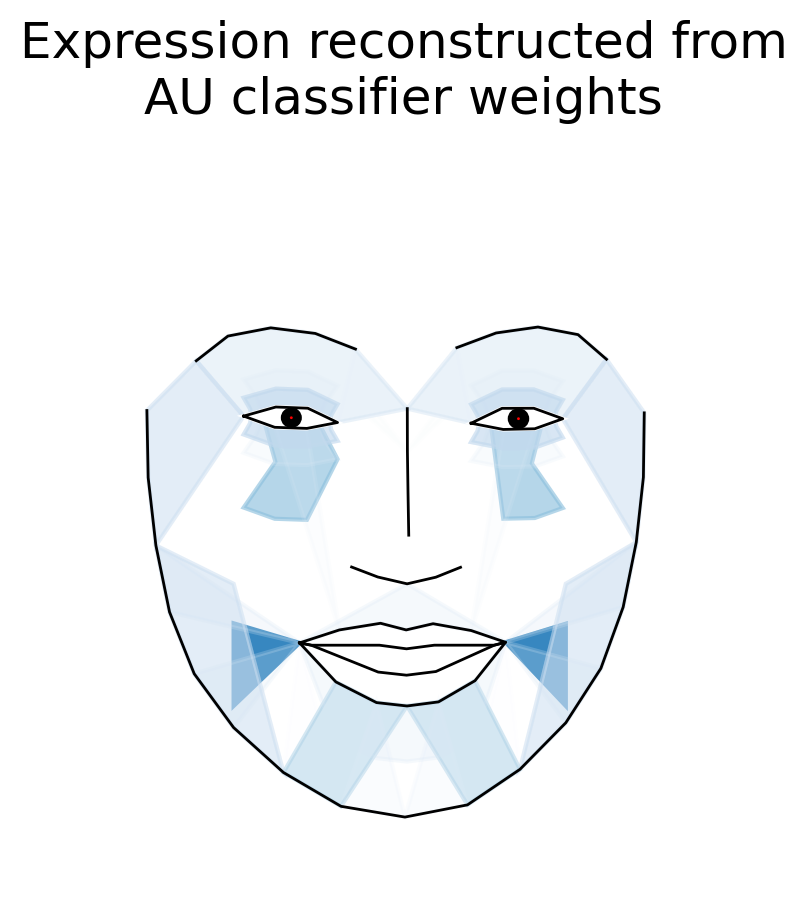

In [30]:
from feat.plotting import plot_face

plot_face(
    au=models['aus'][1].coef_.squeeze(), # the LDA coefs from the AUs pipeline model
    feature_range=(0, 1),
    muscles={"all": "heatmap"},
    title="Expression reconstructed from\nAU classifier weights",
    title_kwargs={'wrap':False}
);
sns.despine(left=True,bottom=True);

plt.savefig('./fig_maker/weights.pdf', bbox_inches='tight');

Even cooler we can *animate* that face expression to **emphasize what's changing.** Here we start from a neutral face:

In [ ]:
from feat.plotting import animate_face

animation = animate_face(
    end=models['aus'][1].coef_.squeeze(), # same as before
    feature_range=(0, 1),
    muscles={'all': 'heatmap'},
    title="Good vs Bad News Classifier Weights",
    save="weights.gif",
)

![](./weights.gif)

# 5.6 Time-series analysis

Finally we might be interested in looking the similarity of the detected features **over time**. We can do that using the `.isc()` method which takes a column and metric to use. Here we compare detected happiness between all pairs of videos.

We use some helper functions to cluster, sort, and plot the correlation matrix. Warmer colors indicate a pair of videos elicited more *similar* detected Happiness over time. We see that some videos show high-correlation in-terms of their detected happiness over-time. This is likely why the classifier above was able to decode conditions so well. 


In [33]:
# ISC returns a video x video pearson correlation matrix
isc = fex.isc(col = "happiness", method='pearson')

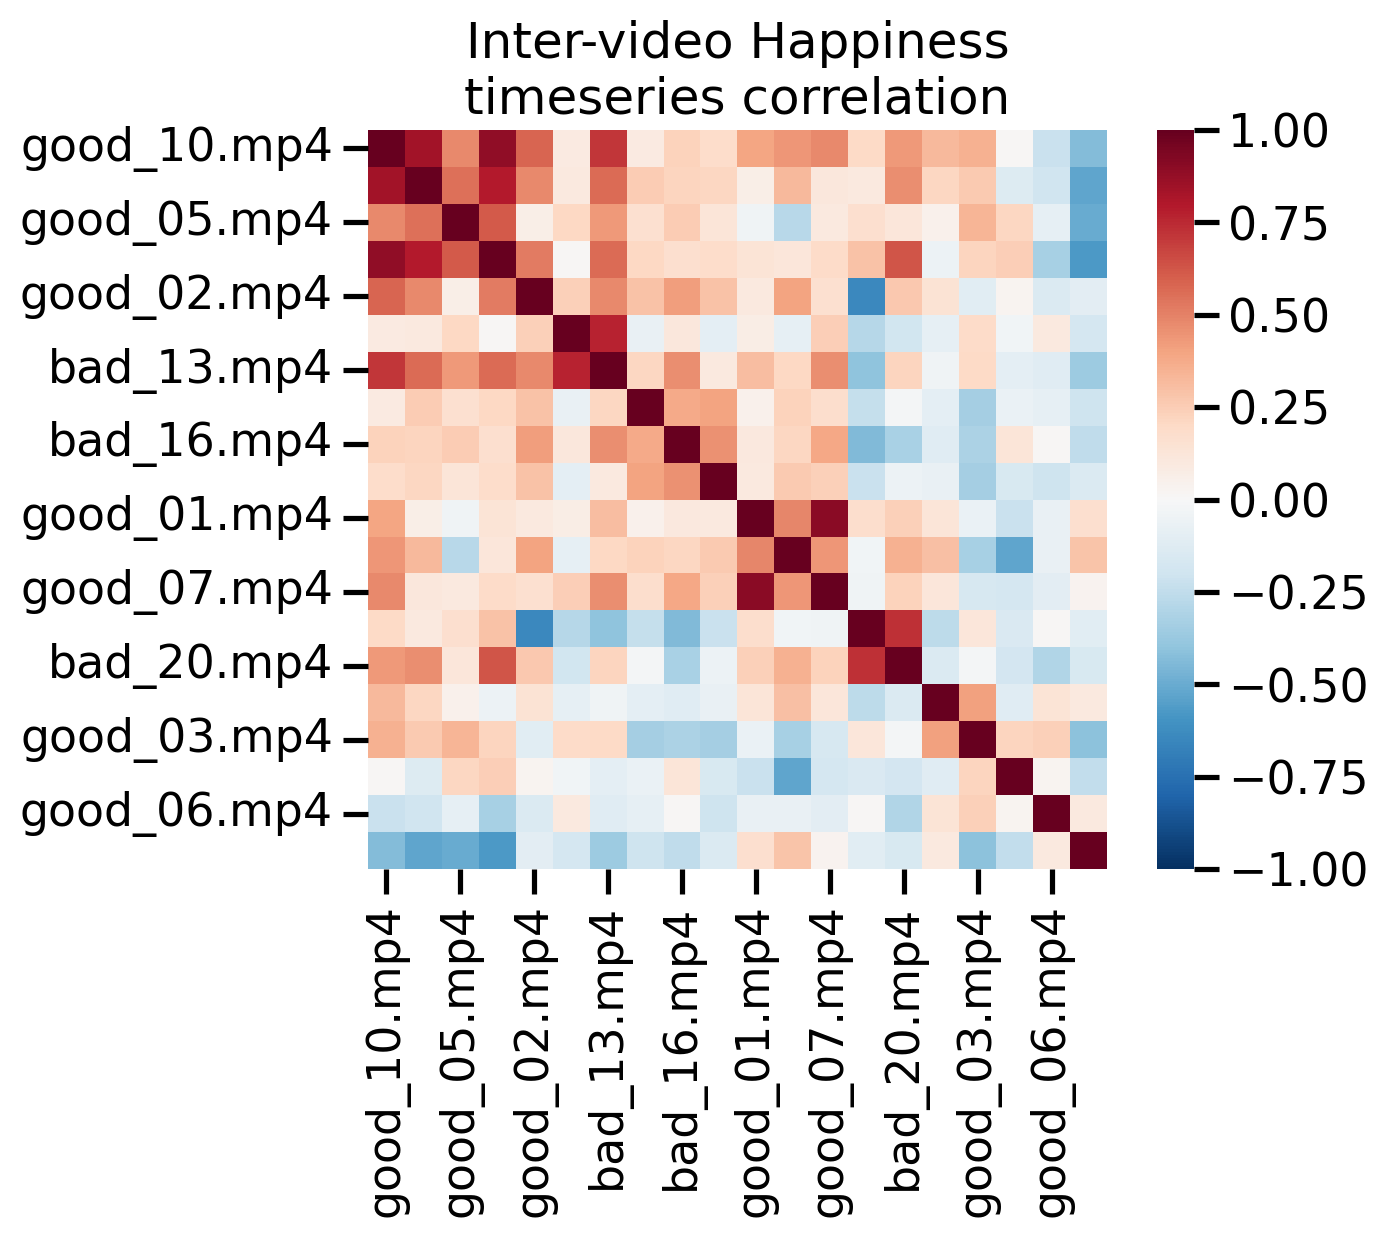

In [34]:
def cluster_corrs(df):
    """Helper to reorder rows and cols of correlation matrix based on clustering"""

    import scipy.cluster.hierarchy as sch

    pairwise_distances = sch.distance.pdist(df)
    linkage = sch.linkage(pairwise_distances, method="complete")
    cluster_distance_threshold = pairwise_distances.max() / 2
    idx_to_cluster_array = sch.fcluster(
        linkage, cluster_distance_threshold, criterion="distance"
    )
    idx = np.argsort(idx_to_cluster_array)
    return df.iloc[idx, :].T.iloc[idx, :]

def add_cond_to_ticks(ax):
    """Helper to add condition info to each tick label"""
    xlabels, ylabels = [], []
    for xlabel, ylabel in zip(ax.get_xticklabels(), ax.get_yticklabels()):
        x_condition = video2condition[xlabel.get_text()]
        y_condition = video2condition[ylabel.get_text()]
        x_new = f"{x_condition[:-4]}_{xlabel.get_text().split('.csv')[0][1:]}"
        y_new = f"{y_condition[:-4]}_{ylabel.get_text().split('.csv')[0][1:]}"
        xlabels.append(x_new)
        ylabels.append(y_new)

    ax.set_xticklabels(xlabels);
    ax.set_yticklabels(ylabels);
    return ax

# Plot it
ax = sns.heatmap(
    cluster_corrs(isc),
    cmap="RdBu_r",
    vmin=-1, vmax=1,
    square=True,
)

ax = add_cond_to_ticks(ax)

ax.set(xlabel="", ylabel="", title="Inter-video Happiness\ntimeseries correlation");
plt.savefig('./fig_maker/isc.pdf', bbox_inches='tight');